# Analysis of the effect of vessel depth

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from pymcx import read_output_file, load_mcx_settings
from spectra import blood_mu_a, melanosome_mu_a, water_mu_a

Load the list of parameters run and the files containing the output and settings files. The constant variables are removed for the summary tables.

In [2]:
parameters = pd.read_csv("params.csv", index_col=0)
# Simulations were run for a couple of different melanin concentrations.
parameters = parameters[parameters["Melanin"]==0.0001]
parameters.loc[:, parameters.nunique()>1]

,VesselDepth,Wavelength,OutputFile,VolumeFile,SettingsFile
0,0.001,7.000000e-07,result_0_0_00.mc2,volume_0.bin,settings_0_0_00.json
1,0.001,7.100000e-07,result_0_0_01.mc2,volume_0.bin,settings_0_0_01.json
2,0.001,7.200000e-07,result_0_0_02.mc2,volume_0.bin,settings_0_0_02.json
3,0.001,7.300000e-07,result_0_0_03.mc2,volume_0.bin,settings_0_0_03.json
4,0.001,7.400000e-07,result_0_0_04.mc2,volume_0.bin,settings_0_0_04.json
...,...,...,...,...,...
352,0.005,8.600000e-07,result_8_0_16.mc2,volume_8.bin,settings_8_0_16.json
353,0.005,8.700000e-07,result_8_0_17.mc2,volume_8.bin,settings_8_0_17.json
354,0.005,8.800000e-07,result_8_0_18.mc2,volume_8.bin,settings_8_0_18.json
355,0.005,8.900000e-07,result_8_0_19.mc2,volume_8.bin,settings_8_0_19.json


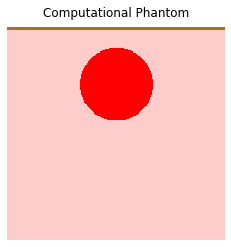

In [3]:
# View the phantom
settings = parameters["SettingsFile"].iloc[0]
volfile = parameters["VolumeFile"].iloc[0]

# Load the phantom settings.
mcx_settings = load_mcx_settings(settings)
dimension = tuple(mcx_settings["Domain"]["Dim"])
volume = np.fromfile(volfile, dtype="uint8").reshape(dimension + (-1,), order="F")

# Visualise the computational phantom.
cmap = matplotlib.colors.ListedColormap([(1,1,1), (163/255, 113/255, 38/255), (1, 0.8, 0.8), (1,0,0)])
plt.imshow(volume[:, 100, :, 0].T, cmap=cmap)
plt.title("Computational Phantom")
plt.axis("off")
plt.show()

# Get an array containing the different sections of the phantom, so we can find the spectra across different regions.
volume_numbered = volume[:, 100, :, 0]
# Labels for each region.
regions = ["Outside", "Coupling Layer", "Epidermis", "Background", "Vessel"]

Load the simulated results, convert to a two-dimensional slice.

In [4]:
ms_results = []
# Define in the independent variable which is varied in the experiment.
variable = "VesselDepth"
labels = parameters[variable].unique()
for dep_variable in labels:
    selection = parameters[parameters[variable] == dep_variable]
    test = np.zeros((200, 200, 21), order="F")
    for i, (result_file, settings_file) in enumerate(zip(selection["OutputFile"], selection["SettingsFile"])):
        settings = load_mcx_settings(settings_file)
        result = read_output_file(result_file, settings)
        test[:, :, i] = np.sum(result[:, 75:125, :, 0], axis=1)
        # test[:, :, i] = result[:, 100, :, 0]
    ms_results.append(test)

## Total energy absorption over the blood vessel averaged over wavelength

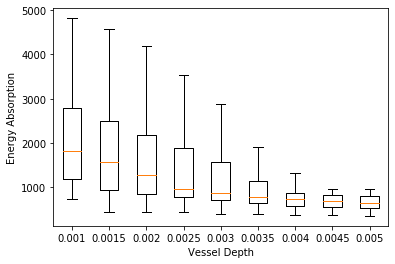

In [5]:
plt.boxplot([np.mean(s[volume_numbered == 4], axis=1) for s in ms_results], showfliers=False, labels=labels)
plt.xlabel("Vessel Depth")
plt.ylabel("Energy Absorption")
plt.show()

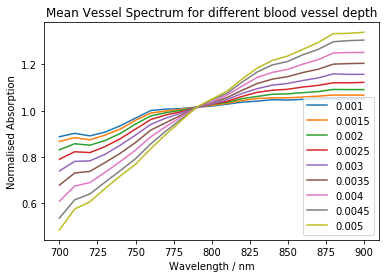

In [6]:
# Calculate the mean absorption spectra over the entire blood vessel over the independent variable.
mean_specs = [np.mean(result[volume_numbered == 4], axis=0) for result in ms_results]

wavelengths = parameters["Wavelength"].unique()
for spec, label in zip(mean_specs, labels):
    plt.plot(1e9*wavelengths, spec/np.mean(spec), label=label)
plt.legend()
plt.xlabel("Wavelength / nm")
plt.ylabel("Normalised Absorption")
plt.title("Mean Vessel Spectrum for different blood vessel depth")
plt.show()

# Spectral Unmixing

In [7]:
# Load the basis spectra
hb = blood_mu_a(wavelengths, 0, water = False)
hbo2 = blood_mu_a(wavelengths, 1, water = False)
water = water_mu_a(wavelengths)
melanin = melanosome_mu_a(wavelengths)
test = np.ones_like(wavelengths)

# Calculate the forward and (pseudo)-inverse matrices
spectra_matrix = np.array([hb, hbo2, water, melanin]).T
inv_matrix = np.linalg.pinv(spectra_matrix)

# Apply the unmixing matrix
unmixed = [np.dot(result, inv_matrix.T) for result in ms_results]
so2 = [M[:, :, 1]/(M[:, :, 1] + M[:, :, 0]) for M in unmixed]
THb = [M[:, :, 1]+M[:, :, 0] for M in unmixed]

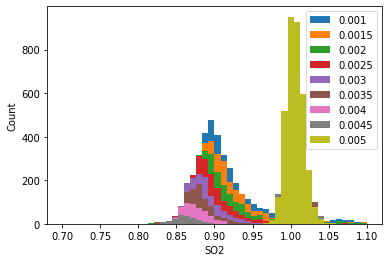

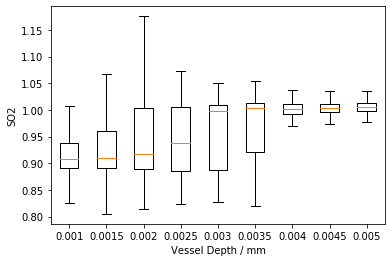

In [8]:
for s, label in zip(so2, labels):
    plt.hist(s[volume_numbered == 4], bins=50, range=(0.7,1.1), label=label)
plt.xlabel("SO2")
plt.ylabel("Count")
plt.legend()
plt.show()
plt.boxplot([s[volume_numbered == 4] for s in so2], showfliers=False, labels=labels)
plt.xlabel("Vessel Depth / mm")
plt.ylabel("SO2")
plt.show()

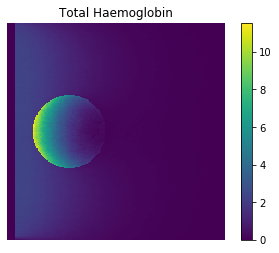

In [9]:
n=0
plt.imshow(THb[n])
plt.colorbar()
plt.axis("off")
plt.title("Total Haemoglobin")
plt.show()

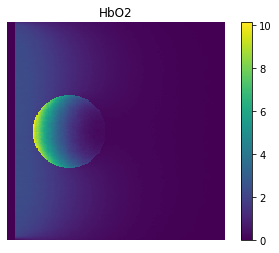

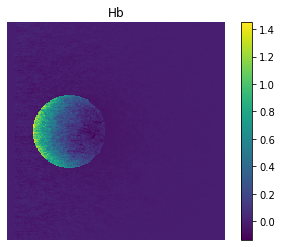

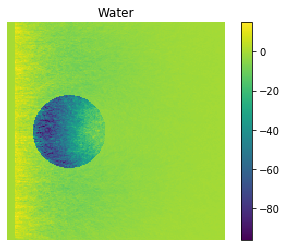

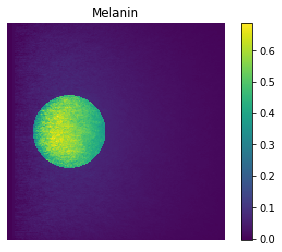

In [10]:
plt.imshow(unmixed[n][:, :, 1])
plt.colorbar()
plt.axis("off")
plt.title("HbO2")
plt.show()
plt.imshow(unmixed[n][:, :, 0])
plt.colorbar()
plt.axis("off")
plt.title("Hb")
plt.show()
plt.imshow(unmixed[n][:, :, 2])
plt.colorbar()
plt.axis("off")
plt.title("Water")
plt.show()
plt.imshow(unmixed[n][:, :, 3])
plt.colorbar()
plt.title("Melanin")
plt.axis("off")
plt.show()